# Gravity model

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pandas.stats.api import ols
%pylab inline
RootPath = '/Users/CQ/Documents/Project1'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from GravModel import GravModel as GM

Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`


## Since basically the numerical values of $ln(W^{out})$ and $ln(W^{in})$ are symmetrically the same, we only present the results regarding $ln(W^{out})$

### Notes for following function:
* The input argument **level** is for the number of groups, i.e. different colors.
* For each zip code, its correspondent value is now **$ln(W^{out}_{zip}) - ln(area_{zip})$** instead of the simple **$ln(W^{out}_{zip})$**, so we can have a clearer look at the density instead of cumulative effect (although subtracting ln(area) would yield all negative results)
* The brighter color indicates the areas with higher values (**$ln(W^{out}_{zip}) - ln(area_{zip})$**), namely higher mobility density. So the 10% in our legend means the "bottom 10%"

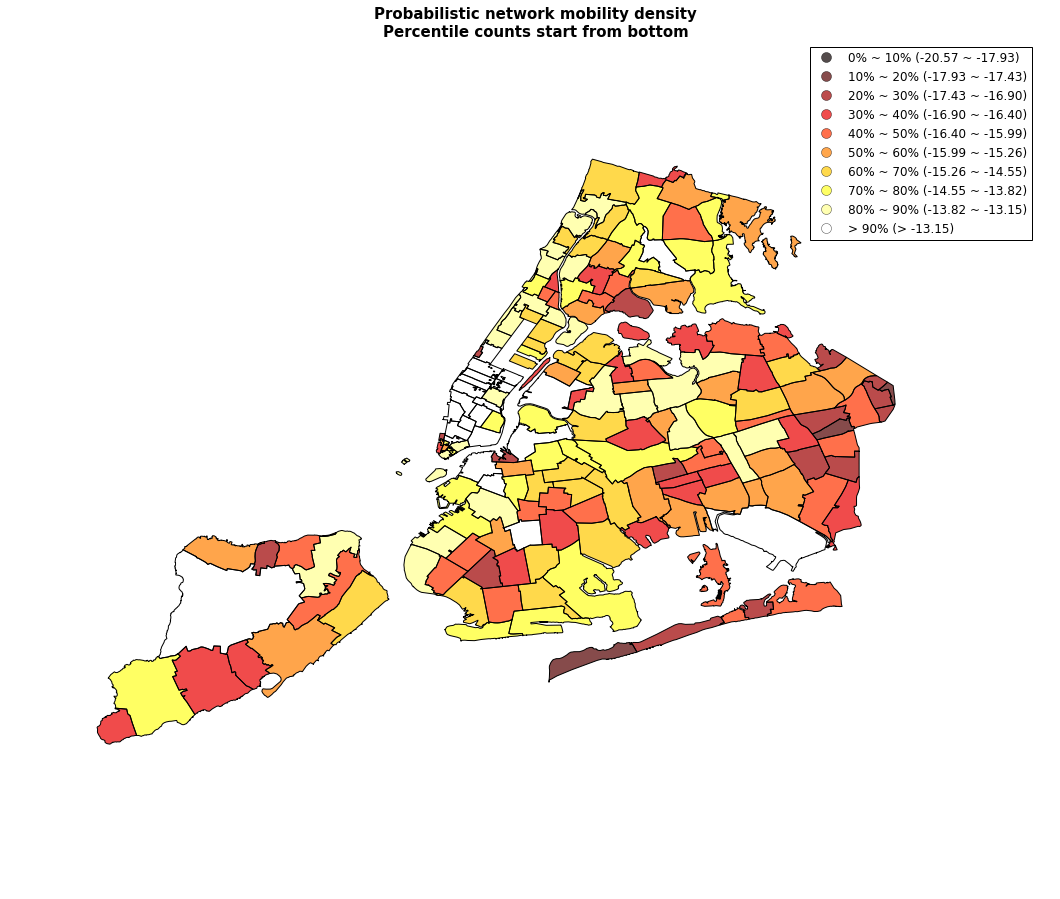

In [3]:
fig1 = plt.figure(figsize=(18,15))
GM.PlotMapPart(fig1, GM.W_out2, title = 'Probabilistic network mobility density\nPercentile counts start from bottom',
               size = 111, levels = 10)

## We take a glance at the relationship of $ln(W^{out}_i)$ vs $ln(T_i)$
## where $T_i$ denotes the number of tweets posted within zip code $i$

The coefficients of this model are: c = 0.906160, d = -5.741231
The R square of this model is 0.923247


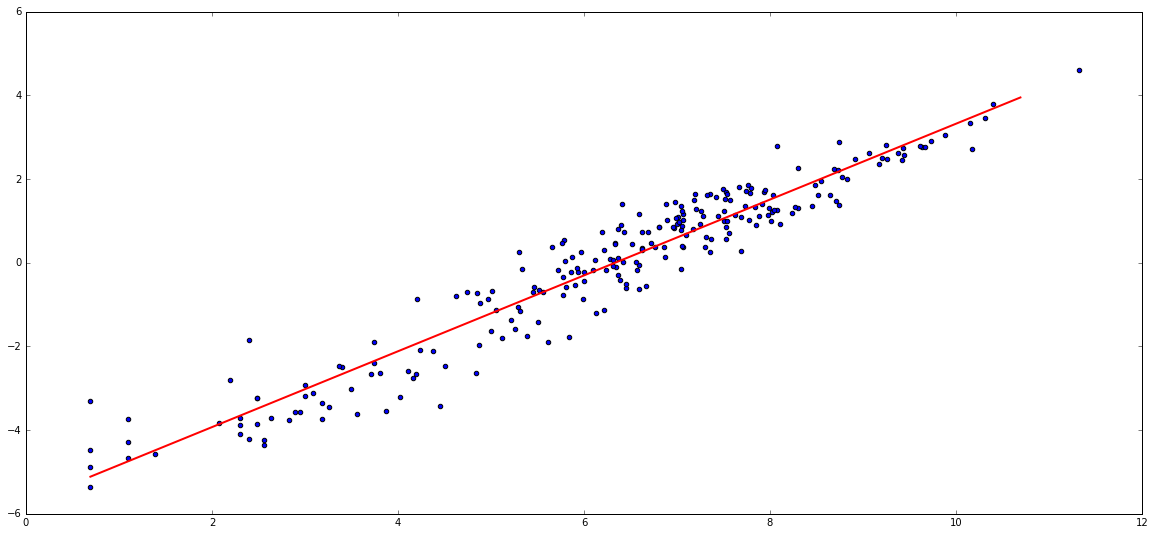

In [4]:
X = GM.DF_Wout2.log_cent
Y = GM.DF_Wout2.weight
WOvsT = ols(x=X,y=Y)
(c,d) = WOvsT.summary_as_matrix.loc['beta',:]
plt.scatter(X, Y)
plt.plot(np.arange(min(X), max(X)), [c*i+d for i in np.arange(min(X), max(X))], '-r', lw=2)
print('The coefficients of this model are: c = %f, d = %f'%(c,d))
print('The R square of this model is %f'%WOvsT.r2)

### So the values of $ln(W^{out}_i)$ are indeed showing strong linear correlation with $ln(T_i)$, which inspires us to predict $ln(W^{out}_i)$ as long as $T_i$ are available.
### And the model looks like this $$ln(W^{out}_i) \approx 0.906160 \cdot ln(T_i) - 5.741231$$ or equivalently, $$W^{out}_i \approx  0.00321 \cdot T^{0.90616}_i$$

## Next we present the $ln(f(distance))$ with respect to the average distance within each bin, where the bins are determined by the percentile of distribution of all distance data in NYC

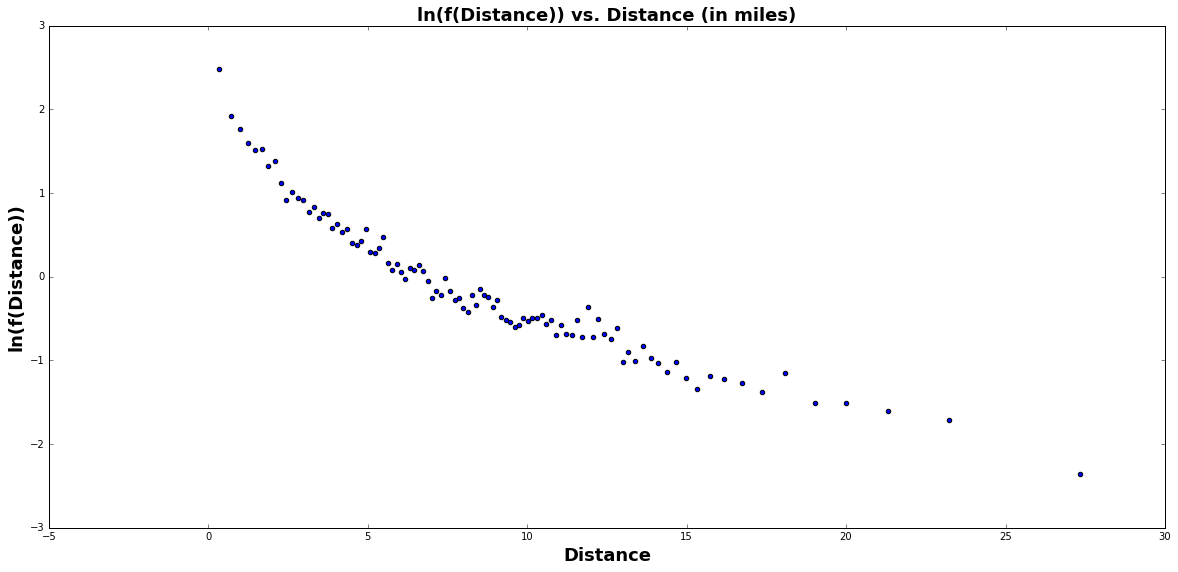

In [5]:
plt.scatter(GM.DistMean2, GM.F_Dist2.f_Dist)
plt.title('ln(f(Distance)) vs. Distance (in miles)', fontweight = 'bold', size = 18)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('Distance', fontweight = 'bold', size = 18)

## It appears that the $ln(f(distance))$ does look like a logarithm function (with negative sign of course), and we now fit it with multiple models
### For better approximation effect, we will leave out the last ten or fifteen points as outliers if needed, as we believe that once the distance has passed a certain "threshold", the impact of it will become irrelavant, and we will use "15 miles" as this threshold judging by the plot (which, currently, covers more than 88% of the all distance data in NYC)

# Model 1 $$f(dist) = \frac {1}{a \cdot dist + b}$$

In [6]:
dist_range = np.arange(0.5,25, 0.1)

The coefficients of this model are a = 0.196572, b = -0.231431
The R square of this model is 0.922512


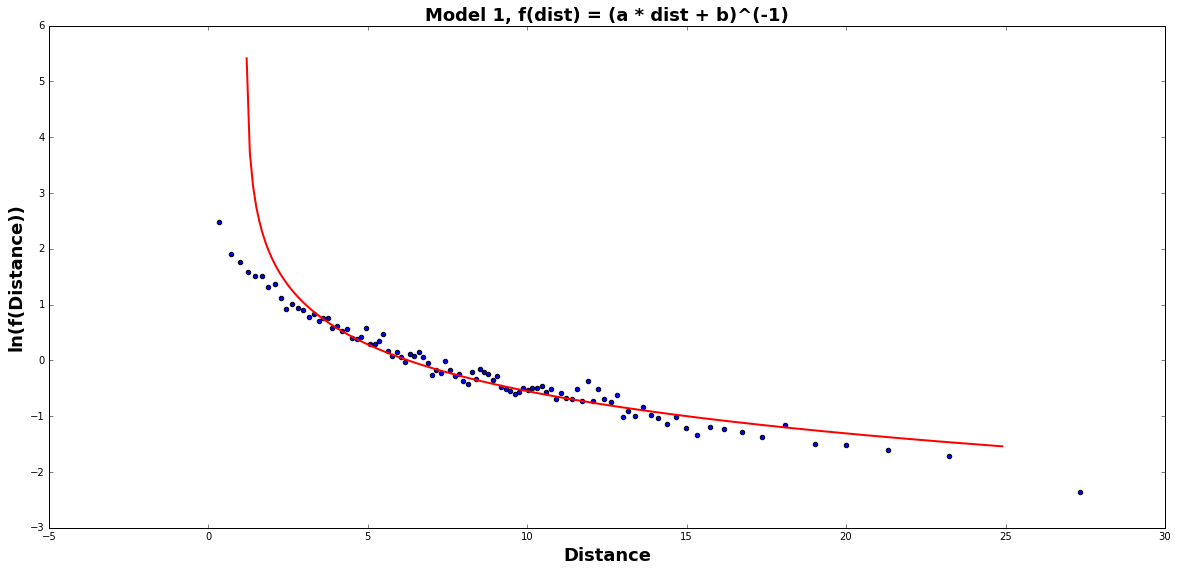

In [7]:
plt.scatter(GM.DistMean2, GM.F_Dist2.f_Dist)
model1 = ols(y = 1.0/exp(GM.F_Dist2.f_Dist)[:-10], x = pd.DataFrame(GM.DistMean2)[:-10])
(a1,b1) = model1.summary_as_matrix.loc['beta']
plt.plot(dist_range, [-log(a1*i+b1) for i in dist_range], '-r', lw = 2)
plt.title('Model 1, f(dist) = (a * dist + b)^(-1)', fontweight = 'bold', size = 18)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('Distance', fontweight = 'bold', size = 18)
print('The coefficients of this model are a = %f, b = %f'%(a1,b1))
print('The R square of this model is %f'%model1.r2)

# Model 2 $$f(dist) = e^b \cdot dist^a$$
## In other words, $ln(f(dist)) = a \cdot ln(dist) + b$

The coefficients of this model are a = -1.107471, b = 2.016561
The R square of this model is 0.957354


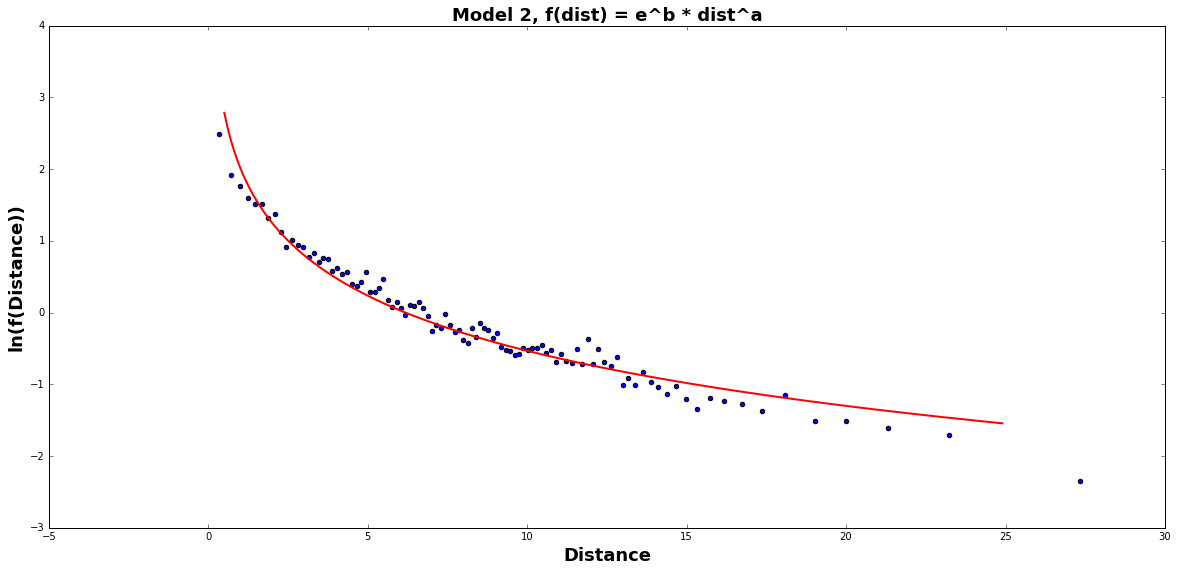

In [8]:
model2 = ols(y = GM.F_Dist2.f_Dist, x = pd.DataFrame(log(GM.DistMean2)))
(a2,b2) = model2.summary_as_matrix.loc['beta']

plt.scatter(GM.DistMean2, GM.F_Dist2.f_Dist)
plt.title('Model 2, f(dist) = e^b * dist^a', fontweight = 'bold', size = 18)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('Distance', fontweight = 'bold', size = 18)
plt.plot(dist_range,[a2*log(i)+b2 for i in dist_range],'-r',lw=2)
print('The coefficients of this model are a = %f, b = %f'%(a2,b2))
print('The R square of this model is %f'%model2.r2)

# Model 3
## More generally, $$f(dist) = a \cdot dist^q + b$$  We start by trying $q$ =-1, and then we search for $q^{*}$ in an interval such that the $R^2$ of our model achieves its maximum at $q^{*}$

The coefficients of this model are a = 4.580498, b = 0.338007
The R square of this model is 0.927525


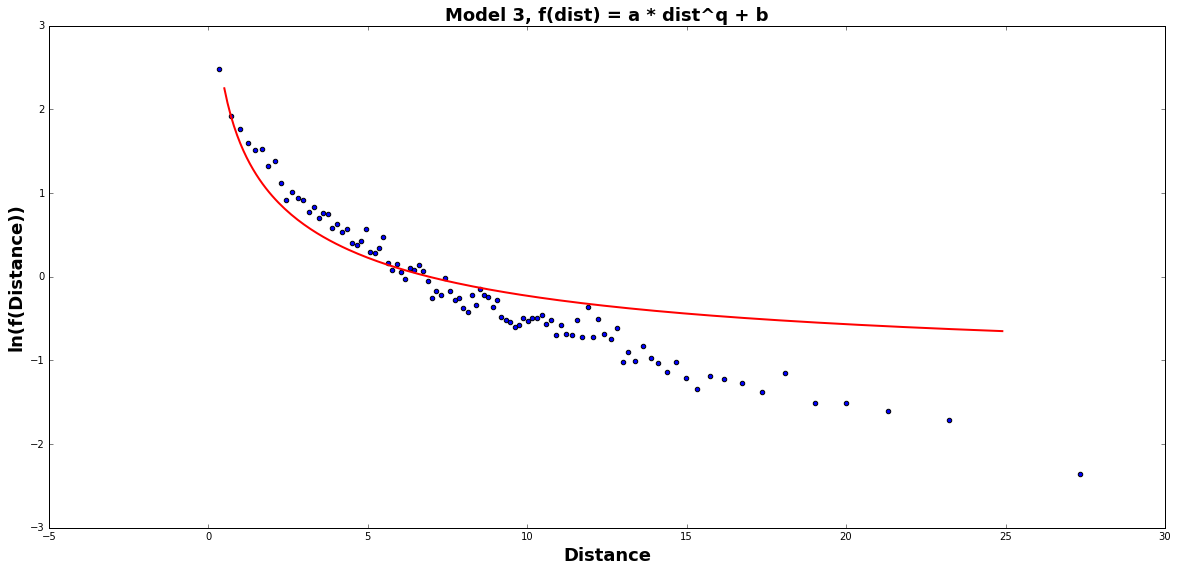

In [9]:
q = -1

x3 = [i**q for i in GM.DistMean2]
plt.scatter(GM.DistMean2, GM.F_Dist2.f_Dist)
model3 = ols(y = exp(GM.F_Dist2.f_Dist), x = pd.DataFrame(x3))
(a3,b3) = model3.summary_as_matrix.loc['beta']
plt.plot(dist_range, [log(a3*(i**q)+b3) for i in dist_range], '-r',lw=2)
plt.ylabel('ln(f(Distance))', fontweight = 'bold', size = 18)
plt.xlabel('Distance', fontweight = 'bold', size = 18)
plt.title('Model 3, f(dist) = a * dist^q + b', fontweight = 'bold', size = 18)
print('The coefficients of this model are a = %f, b = %f'%(a3,b3))
print('The R square of this model is %f'%model3.r2)

The optimal q is -0.620000
The coefficients of this model are a = 6.627180, b = -0.948016
The R square of this model is 0.990390


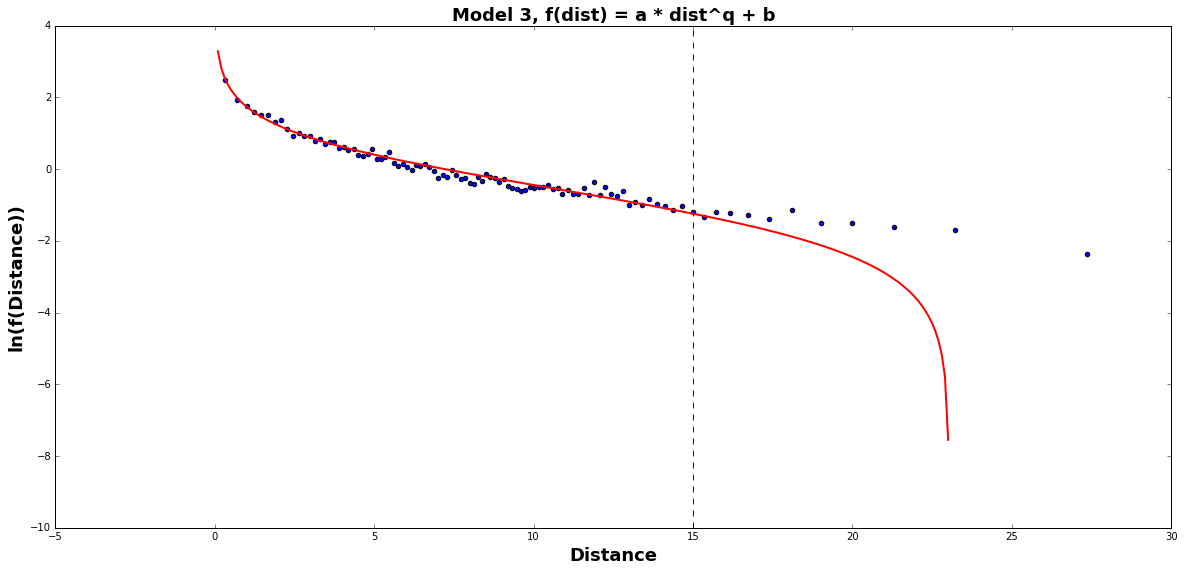

In [10]:
GM.Search_qstar_model3()

## So if we ignore the links "longer than 15 miles"--since the connection on that scale could be very weak in reality--this new model fits the data really well. And statistically speaking, more than 88% of the distance data falls below this threshold.
## (In fact, the distance between Wall Street and Yankee Stadium is less than 13 miles, and  about 18 miles from Central Park to Coney Island)
## Hence, one possible model is $$f(dist) = 6.627180 \cdot dist^{-0.62} - 0.948016$$

# Model 4
## Generalization of model 1:  $$f(dist) = \frac {1}{(a \cdot dist + b)^q}$$

The optimal q is 2.170000
The coefficients of this model are a = 0.083281, b = 0.417067
The R square of this model is 0.972983


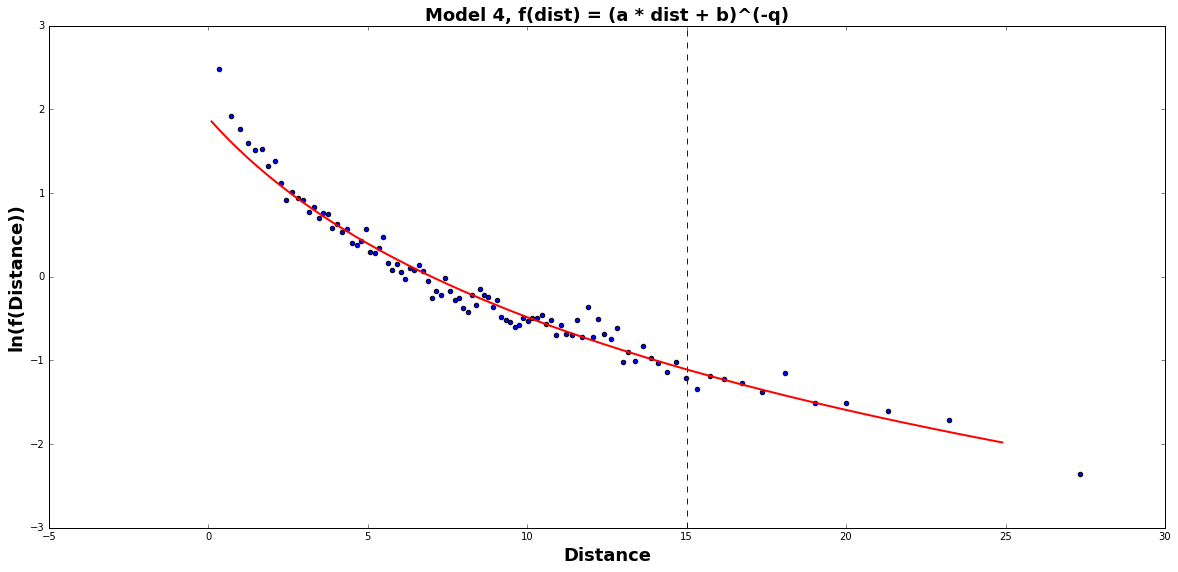

In [11]:
GM.Search_qstar_model4()

## The biggest advantage of model4, compared to model3, is we don't need to drop any so-called "outliers" anymore, this model basically fits for all data. But the $R^2$ drops slightly, and judging from the plot, its prediction accuracy may be weaker than model3 for smaller values (dist < 2 miles).
## The model looks like:  $$f(dist) = \frac {1}{(0.083281 \cdot dist + 0.417067)^{2.17}}$$

#  All parameters are estimated based on Twitter data from Nov. 2015 to Feb. 2016, we'll test these models when new data is available (from March to April)